# STEP 1 - Learning for social influence
Assume that all the properties of the graph are known except for the edge activation
probabilities. Apply the greedy algorithm to the problem of maximizing the expected number
of activated customers, where each edge activation probability is replaced with its upper
confidence bound (in a UCB1-like fashion). Furthermore, apply the greedy algorithm to the
same problem when estimating edge activation probabilities with Beta distributions and
sampling is used (in a TS-like fashion). Report the plots with the average (over a sufficiently
large number of runs) value and standard deviation of the cumulative regret, cumulative
reward, instantaneous regret, and instantaneous reward.

In [4]:
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import random
from scipy.optimize import linear_sum_assignment


In [5]:
class Environment:
    def __init__(self, probabilities):
        self.probabilities = probabilities

    def round(self, pulled_arm):
        reward = np.random.binomial(1, self.probabilities[pulled_arm])
        return reward

In [7]:
class Learner:
    def __init__(self, n_arms) -> None:
        self.n_arms = n_arms
        self.t = 0
        self.rewards_per_arm = x = [[] for i in range(n_arms)]
        self.collected_rewards = np.array([])

    def update_observations(self, pulled_arm, reward):
        self.rewards_per_arm[pulled_arm].append(reward)
        self.collected_rewards = np.append(self.collected_rewards, [reward])
        self.t += 1

In [8]:
class UCBLearner(Learner):
    def __init__(self, n_arms):
        super().__init__(n_arms)
        self.empirical_means = np.zeros(n_arms)
        self.n_pulls = np.zeros(n_arms)  # count the number of times each arm has been pulled
        self.confidence = np.array([np.inf] * n_arms)
    
    def pull_arm(self):
        upper_confidence_bound = self.empirical_means + self.confidence
        return np.random.choice(np.where(upper_confidence_bound == upper_confidence_bound.max())[0])

    def update(self, pulled_arm, reward):
        self.t += 1
        self.n_pulls[pulled_arm] += 1
        self.empirical_means[pulled_arm] = (self.empirical_means[pulled_arm] * (self.n_pulls[pulled_arm] - 1) + reward) / self.n_pulls[pulled_arm]
        for a in range(self.n_arms):
            #n_samples = max(1, self.n_pulls[a])
            n_samples = self.n_pulls[a]
            self.confidence[a] = np.sqrt(2 * np.log(self.t) / n_samples) if n_samples > 0 else np.inf

        self.update_observations(pulled_arm, reward)
        
    def expectations(self):
        return self.empirical_means


In [9]:
class TSLearner(Learner):
    def __init__(self, n_arms):
        super().__init__(n_arms)
        self.beta_parameters = np.ones((n_arms, 2))
        self.means = np.zeros(n_arms)  # Initialize the means array with zeros

    def pull_arm(self):
        idx = np.argmax(np.random.beta(self.beta_parameters[:, 0], self.beta_parameters[:, 1]))
        return idx
    
    def update(self, pulled_arm, reward):
        self.t += 1
        self.update_observations(pulled_arm, reward)
        self.beta_parameters[pulled_arm, 0] = self.beta_parameters[pulled_arm, 0] + reward
        self.beta_parameters[pulled_arm, 1] = self.beta_parameters[pulled_arm, 1] + 1.0 - reward
        for arm in range(self.n_arms):
            alpha = self.beta_parameters[arm, 0]
            beta = self.beta_parameters[arm, 1]
            if alpha == 1 and beta == 1: 
                self.means[arm] = 0
            else:
                self.means[arm] = alpha / (alpha + beta)

    def expectations(self):
        return self.means

        

In [12]:
def simulate_episode(init_prob_matrix, seeds:list, max_steps):
    prob_matrix=init_prob_matrix.copy()
    n_nodes=prob_matrix.shape[0]

    #set up seeds
    active_nodes=np.zeros(n_nodes)

    for seed in seeds:
        active_nodes[seed]=1

    history=np.array([active_nodes])

    newly_active_nodes=active_nodes

    t=0

    while (t<max_steps and np.sum(newly_active_nodes)>0):
        #retrieve probability of edge activations
        p = (prob_matrix.T*active_nodes).T
        activated_edges=p>np.random.rand(p.shape[0], p.shape[1])
        #remove activated edges
        prob_matrix=prob_matrix*((p!=0)==activated_edges)
        #update active nodes
        newly_active_nodes=(np.sum(activated_edges, axis=0)>0)*(1-active_nodes)
        #print(newly_active_nodes)
        active_nodes=np.array(active_nodes+newly_active_nodes)
        #print(active_nodes)
        history=np.concatenate((history, [newly_active_nodes]), axis=0)
        t+=1
    return history, active_nodes

def test_seed(seeds, prob_matrix, k, max_steps):
    reward = 0
    for i in range(k):
        history, active_nodes=simulate_episode(prob_matrix, seeds, max_steps)
        reward+=np.sum(active_nodes)
    return reward/k

def greedy_algorithm(init_prob_matrix, budget, k, max_steps):
    prob_matrix=init_prob_matrix.copy()
    n_nodes=prob_matrix.shape[0]

    seeds=[]
    for j in range(budget):
        rewards=np.zeros(n_nodes)

        for i in tqdm(range(n_nodes)):
            if i not in seeds:
                rewards[i]=test_seed([i]+seeds, prob_matrix, k, max_steps)
        seeds.append(np.argmax(rewards))

    return seeds

In [13]:
def hungarian_algorithm(matrix):
    m = matrix.copy()
    n_rows, n_cols = m.shape
    max_val = np.max(m)

    if n_rows > n_cols:
        m = np.pad(m, ((0, 0), (0, n_rows - n_cols)), mode='constant', constant_values=max_val)
    elif n_cols > n_rows:
        m = np.pad(m, ((0, n_cols - n_rows), (0, 0)), mode='constant', constant_values=max_val)

    assigned_rows, assigned_cols = linear_sum_assignment(m)

    assignment = np.zeros_like(m, dtype=int)
    assignment[assigned_rows, assigned_cols] = 1

    return assignment[:n_rows, :n_cols] * matrix, assignment[:n_rows, :n_cols]

def get_reward(node_class, product_class, rewards_parameters):
    return 100-np.random.normal(rewards_parameters[0][node_class, product_class], rewards_parameters[1][node_class, product_class])


def clairvoyant(graph_probabilities, customer_assignments, rewards_parameters, n_exp, seeds = None):

    hungarian_matrix = hungarian_algorithm(rewards_parameters[0])[1]

    reward_per_experiment = [[] for i in range(n_exp)]
    
    if seeds == None:
        opt_seeds=greedy_algorithm(graph_probabilities, 3, 100, 100)
    else:
        opt_seeds = seeds


    for e in tqdm(range(n_exp)):

        history = simulate_episode(graph_probabilities, opt_seeds, 10)[0]
        activation_flow = np.concatenate([np.where(row == 1)[0] for row in history]).tolist()
        class_activation_flow = customer_assignments[activation_flow]
        exp_reward = 0

        units = [3,3,3]

        while units != [0,0,0]:

            for customer in class_activation_flow:


                # find mean of matching reward
                nonzero_index = np.nonzero(hungarian_matrix[customer])
                product_class = int(nonzero_index[0][0])

                if units[product_class] != 0:
                    reward = get_reward(customer, product_class, rewards_parameters)
                    units[product_class] = units[product_class] -1

                else:
                    instock_units = [index for index, value in enumerate(units) if value != 0]
                    if instock_units:  # Check if instock_units is not empty before choosing
                        product_class = random.choice(instock_units)
                        reward = get_reward(customer, product_class, rewards_parameters)
                        units[product_class] -= 1
                    else:
                        # Handle the case when units is empty (no available units)
                        reward = 0


                exp_reward = exp_reward + reward

            reward_per_experiment[e] = exp_reward

    return np.mean(reward_per_experiment), np.std(reward_per_experiment)

# Estimation of probabilities

In [11]:
n_arms = 30
edge_rate=0.07
graph_structure = np.random.binomial(1, edge_rate, (n_arms, n_arms))
graph_probabilities = np.random.uniform(0.1, 0.9, (n_arms, n_arms)) * graph_structure
graph_probabilities

array([[0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.47477353, 0.        , 0.75414062, 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.15826293, 0.        , 0.32717837, 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.35125197, 0.        , 0.        , 0.        , 0.20733735,
        0.        , 0.        , 0.        , 0.

### UCB Learner

In [14]:
def UCB_Generate_Probability_Estimates(p, n_arms=30, T = 365, n_experiments=100):

    experimentS_means_at_each_round = np.empty((n_experiments, T, n_arms))

    for e in tqdm(range(0, n_experiments)):
        # Initialize environment
        ucb_env = Environment(probabilities=p)
        # Initialize learner
        ucb_learner = UCBLearner(n_arms)

        for t in range(0, T):
            # SW-UCB Learner
            pulled_arm = ucb_learner.pull_arm()
            reward = ucb_env.round(pulled_arm)
            ucb_learner.update(pulled_arm, reward)

            # At each round memorize a copy of the means of each arm
            expected_rew = ucb_learner.expectations()
            experimentS_means_at_each_round[e, t] = expected_rew.copy()

    return experimentS_means_at_each_round

In [15]:
import numpy as np

UCB_estimated_graph_probabilities = []

for index in range(len(graph_probabilities)):
    print("Estimating Arm", index)
    arm_probabilities = UCB_Generate_Probability_Estimates(graph_probabilities[index])
    arm_probabilities = np.mean(arm_probabilities, axis=0)
    UCB_estimated_graph_probabilities.append(arm_probabilities)

UCB_estimated_graph_probabilities = np.array(UCB_estimated_graph_probabilities)
UCB_estimated_graph_probabilities = np.transpose(UCB_estimated_graph_probabilities, (1, 0, 2))


for table in UCB_estimated_graph_probabilities:
    table = table*graph_structure


Estimating Arm 0


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:06<00:00, 14.86it/s]


Estimating Arm 1


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:07<00:00, 14.18it/s]


Estimating Arm 2


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:06<00:00, 14.29it/s]


Estimating Arm 3


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:06<00:00, 16.18it/s]


Estimating Arm 4


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:06<00:00, 15.74it/s]


Estimating Arm 5


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:06<00:00, 15.14it/s]


Estimating Arm 6


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:06<00:00, 14.90it/s]


Estimating Arm 7


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:06<00:00, 15.37it/s]


Estimating Arm 8


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:06<00:00, 14.42it/s]


Estimating Arm 9


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:06<00:00, 15.27it/s]


Estimating Arm 10


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:07<00:00, 14.11it/s]


Estimating Arm 11


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:06<00:00, 15.78it/s]


Estimating Arm 12


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:06<00:00, 14.61it/s]


Estimating Arm 13


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:06<00:00, 15.31it/s]


Estimating Arm 14


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:06<00:00, 15.21it/s]


Estimating Arm 15


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:06<00:00, 14.89it/s]


Estimating Arm 16


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:07<00:00, 14.09it/s]


Estimating Arm 17


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:07<00:00, 14.26it/s]


Estimating Arm 18


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:06<00:00, 15.19it/s]


Estimating Arm 19


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:06<00:00, 14.38it/s]


Estimating Arm 20


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:06<00:00, 15.10it/s]


Estimating Arm 21


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:07<00:00, 13.95it/s]


Estimating Arm 22


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:06<00:00, 14.86it/s]


Estimating Arm 23


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:06<00:00, 15.80it/s]


Estimating Arm 24


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:06<00:00, 15.61it/s]


Estimating Arm 25


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:06<00:00, 15.00it/s]


Estimating Arm 26


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:06<00:00, 14.92it/s]


Estimating Arm 27


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:06<00:00, 14.66it/s]


Estimating Arm 28


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:06<00:00, 14.36it/s]


Estimating Arm 29


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:06<00:00, 14.51it/s]


array([[[0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        ...,
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.06      , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ]],

       [[0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        ...,
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.08      , 0.        ],
        [0. 

### TS Learner

In [29]:
def TS_Generate_Probability_Estimates(p, n_arms=30, T = 365, n_experiments=100):

    experimentS_means_at_each_round = np.empty((n_experiments, T, n_arms))

    for e in tqdm(range(0, n_experiments)):
        # Initialize environment
        ts_env = Environment(probabilities=p)
        # Initialize learner
        ts_learner = TSLearner(n_arms)

        for t in range(0, T):
            # TS-UCB Learner
            pulled_arm = ts_learner.pull_arm()
            reward = ts_env.round(pulled_arm)
            ts_learner.update(pulled_arm, reward)

            # At each round memorize a copy of the means of each arm
            expected_rew = ts_learner.expectations()
            experimentS_means_at_each_round[e, t] = expected_rew.copy()

    return experimentS_means_at_each_round

In [30]:
import numpy as np

TS_estimated_graph_probabilities = []

for index in range(len(graph_probabilities)):
    print("Estimating Arm", index)
    arm_probabilities = TS_Generate_Probability_Estimates(graph_probabilities[index])
    arm_probabilities = np.mean(arm_probabilities, axis=0)
    TS_estimated_graph_probabilities.append(arm_probabilities)

TS_estimated_graph_probabilities = np.array(TS_estimated_graph_probabilities)
TS_estimated_graph_probabilities = np.transpose(TS_estimated_graph_probabilities, (1, 0, 2))

for table in TS_estimated_graph_probabilities:
    table = table*graph_structure


Estimating Arm 0


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 21.65it/s]


Estimating Arm 1


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 22.03it/s]


Estimating Arm 2


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 22.71it/s]


Estimating Arm 3


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 21.75it/s]


Estimating Arm 4


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 21.88it/s]


Estimating Arm 5


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 21.91it/s]


Estimating Arm 6


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 22.79it/s]


Estimating Arm 7


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 22.59it/s]


Estimating Arm 8


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 22.04it/s]


Estimating Arm 9


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 21.71it/s]


Estimating Arm 10


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 21.75it/s]


Estimating Arm 11


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 21.75it/s]


Estimating Arm 12


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 22.74it/s]


Estimating Arm 13


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 21.42it/s]


Estimating Arm 14


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 22.62it/s]


Estimating Arm 15


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 22.36it/s]


Estimating Arm 16


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 22.06it/s]


Estimating Arm 17


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 22.03it/s]


Estimating Arm 18


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 22.66it/s]


Estimating Arm 19


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 21.46it/s]


Estimating Arm 20


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 21.57it/s]


Estimating Arm 21


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 20.71it/s]


Estimating Arm 22


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 21.45it/s]


Estimating Arm 23


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 21.60it/s]


Estimating Arm 24


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 21.96it/s]


Estimating Arm 25


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 21.80it/s]


Estimating Arm 26


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 22.13it/s]


Estimating Arm 27


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 22.41it/s]


Estimating Arm 28


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 20.20it/s]


Estimating Arm 29


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 21.75it/s]


array([[[0.01      , 0.02666667, 0.01333333, ..., 0.        ,
         0.00666667, 0.00666667],
        [0.02      , 0.01      , 0.00666667, ..., 0.00666667,
         0.01      , 0.00666667],
        [0.03333333, 0.01666667, 0.00666667, ..., 0.01      ,
         0.00666667, 0.01      ],
        ...,
        [0.00333333, 0.01666667, 0.01333333, ..., 0.01      ,
         0.00666667, 0.00666667],
        [0.01666667, 0.01333333, 0.00666667, ..., 0.01      ,
         0.01333333, 0.01      ],
        [0.00333333, 0.01      , 0.00666667, ..., 0.        ,
         0.01333333, 0.01333333]],

       [[0.02333333, 0.04666667, 0.02666667, ..., 0.00333333,
         0.02      , 0.02      ],
        [0.02333333, 0.02333333, 0.01      , ..., 0.02      ,
         0.01666667, 0.02      ],
        [0.05      , 0.02      , 0.03      , ..., 0.02333333,
         0.01666667, 0.01333333],
        ...,
        [0.01      , 0.02333333, 0.02      , ..., 0.02666667,
         0.02666667, 0.02666667],
        [0.0

In [34]:
new_TS_estimated_graph_probabilities = []
for table in TS_estimated_graph_probabilities:
    cleaned_table = table*graph_structure
    new_TS_estimated_graph_probabilities.append(cleaned_table)


In [37]:
TS_estimated_graph_probabilities = new_TS_estimated_graph_probabilities

#### Evaluating Edge Activation Prob. Estimation

In [ ]:
repeated_array = np.tile(graph_probabilities, (365, 1, 1))
original_probabilities = repeated_array.reshape((365, 30, 30))

In [ ]:
UCB_nodes_probabilities = []
for i in range(len(UCB_estimated_graph_probabilities)):
    nodes_only = UCB_estimated_graph_probabilities[i]*graph_structure
    UCB_nodes_probabilities.append(nodes_only)

UCB_regret = np.sum((original_probabilities - UCB_nodes_probabilities), axis=(1, 2))

In [ ]:
TS_nodes_probabilities = []
for i in range(len(TS_estimated_graph_probabilities)):
    nodes_only = TS_estimated_graph_probabilities[i]*graph_structure
    TS_nodes_probabilities.append(nodes_only)

TS_regret = np.sum((original_probabilities - TS_nodes_probabilities), axis=(1, 2))

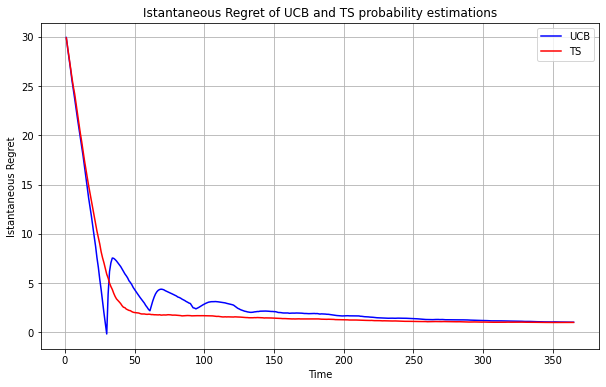

In [64]:
time_periods = range(1, 366)

# Plot the two lists
plt.figure(figsize=(10, 6))

plt.plot(time_periods, UCB_regret, color='blue', linestyle='-', label='UCB')
plt.plot(time_periods, TS_regret, color='red', linestyle='-', label='TS')

plt.xlabel('Time')
plt.ylabel('Istantaneous Regret')
plt.title('Istantaneous Regret of UCB and TS probability estimations')

plt.legend()
plt.grid()

plt.show()





## Computing Rewards 

In [16]:
node_classes = 3
product_classes = 3
products_per_class = 3
T = 365

means = np.random.uniform(25, 100, size=(3,3))
std_dev = np.random.randint(1, 30, size=(3,3))
rewards_parameters = (means, std_dev)
customer_assignments = np.random.choice([0,1,2], size=30)

(array([[62.03867995, 88.03572799, 96.88148332],
        [83.08954923, 62.69306104, 45.55943191],
        [60.97890542, 77.00004321, 76.53982925]]),
 array([[ 5, 20, 15],
        [ 9, 26, 15],
        [16, 29, 21]]))

#### Rewards with UCB Learner

In [17]:
n_exp = 5

UCB_mean_rewards_per_round = []
UCB_std_dev_rewards_per_round = []
for table in tqdm(range(T)):
    table = UCB_estimated_graph_probabilities[table]
    clairvoyant_output =  clairvoyant(table, customer_assignments, rewards_parameters, n_exp)
    UCB_mean_rewards_per_round.append(clairvoyant_output[0])
    UCB_std_dev_rewards_per_round.append(clairvoyant_output[1])

100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 105.39it/s]

100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 100.30it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 96.04it/s]

100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 103.59it/s]

100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 103.63it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 81.27it/s]

100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 123.20it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 89.11it/s]

100%|███████████████████████████

KeyboardInterrupt: 

#### Rewards with TS Learner


In [44]:
n_exp = 5

TS_mean_rewards_per_round = []
TS_std_dev_rewards_per_round = []
for table in tqdm(range(T)):
    table = TS_estimated_graph_probabilities[table]
    clairvoyant_output =  clairvoyant(table, customer_assignments, rewards_parameters, n_exp)
    TS_mean_rewards_per_round.append(clairvoyant_output[0])
    TS_std_dev_rewards_per_round.append(clairvoyant_output[1])

100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 134.66it/s]

100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 138.97it/s]

100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 124.06it/s]

100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 129.80it/s]

100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 106.23it/s]

100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 117.17it/s]

100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 120.30it/s]

100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 105.63it/s]

100%|███████████████████████████

100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 100.95it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 77.33it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 74.05it/s]

100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 100.44it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 78.42it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 69.68it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 97.52it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 67.56it/s]

100%|███████████████████████████

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 79.04it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 54.96it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 57.23it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 68.46it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 50.18it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 48.47it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 72.55it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 53.49it/s]

100%|███████████████████████████

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 47.60it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 64.76it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 46.21it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 44.93it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 61.21it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 45.32it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 43.62it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 63.92it/s]

100%|███████████████████████████

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 41.56it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 57.23it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 40.96it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 39.48it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 58.36it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 42.09it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 38.63it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 59.02it/s]

100%|███████████████████████████

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 55.92it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 40.16it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 39.02it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 55.61it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 41.52it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 42.74it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 55.70it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 40.17it/s]

100%|███████████████████████████

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 39.09it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 53.69it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 39.89it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 41.38it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 55.48it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 39.94it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 42.78it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 54.89it/s]

100%|███████████████████████████

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 54.30it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 39.47it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 38.46it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 54.10it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 40.71it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 41.78it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 55.91it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 41.10it/s]

100%|███████████████████████████

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 40.80it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 56.20it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 40.45it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 39.62it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 55.21it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 39.74it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 38.33it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 56.20it/s]

100%|███████████████████████████

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 55.00it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 38.73it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 43.03it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 52.03it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 41.33it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 38.41it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 55.27it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 40.53it/s]

100%|███████████████████████████

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 55.45it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 40.58it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 39.32it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 53.67it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 39.84it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 36.84it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 56.15it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 40.43it/s]

100%|███████████████████████████

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 41.04it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 39.83it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 53.69it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 39.46it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 41.72it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 57.49it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 40.47it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 42.62it/s]

100%|███████████████████████████

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 39.82it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 56.85it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 39.31it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 41.12it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 55.07it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 40.03it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 42.58it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 57.66it/s]

100%|███████████████████████████

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 54.55it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 39.67it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 36.84it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 52.98it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 40.08it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 39.74it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 54.29it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 39.98it/s]

100%|███████████████████████████

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 39.65it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 42.09it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 55.68it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 41.68it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 39.73it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 53.87it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 38.93it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 40.32it/s]

100%|███████████████████████████

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 39.37it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 55.11it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 36.01it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 39.75it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 55.37it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 39.68it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 40.37it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 54.14it/s]

100%|███████████████████████████

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 56.41it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 35.86it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 35.22it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 56.20it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 40.16it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 42.35it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 55.20it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 39.14it/s]

100%|███████████████████████████

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 39.40it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 42.25it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 55.19it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 35.64it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 38.98it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 52.94it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 37.80it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 37.78it/s]

100%|███████████████████████████

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 38.60it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 55.35it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 39.37it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 38.06it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 56.85it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 35.41it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 39.10it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 55.42it/s]

100%|███████████████████████████

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 55.50it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 35.58it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 34.68it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 54.70it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 35.34it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 39.63it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 55.07it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 35.58it/s]

100%|███████████████████████████

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 54.39it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 39.30it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 42.37it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 53.94it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 40.38it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 39.63it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 53.90it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 35.16it/s]

100%|███████████████████████████

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 39.56it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 40.37it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 52.74it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 36.35it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 40.09it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 52.72it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 38.53it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 38.67it/s]

100%|███████████████████████████

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 43.35it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 54.42it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 38.96it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 41.37it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 54.72it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 39.15it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 41.98it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 54.82it/s]

100%|███████████████████████████

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 52.25it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 35.86it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 36.03it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 55.23it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 38.28it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 43.31it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 54.96it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 39.20it/s]

100%|███████████████████████████

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 36.21it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 40.09it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 51.90it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 38.62it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 43.20it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 54.82it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 39.16it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 38.61it/s]

100%|███████████████████████████

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 39.61it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 53.38it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 39.08it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 38.93it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 54.11it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 39.41it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 40.74it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 55.66it/s]

100%|███████████████████████████

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 52.35it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 39.40it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 39.27it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 53.73it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 35.75it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 38.22it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 53.85it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 39.64it/s]

100%|███████████████████████████

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 53.39it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 40.12it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 40.46it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 53.82it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 39.12it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 37.88it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 56.63it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 35.41it/s]

100%|███████████████████████████

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 38.28it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 37.37it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 55.31it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 39.49it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 41.90it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 54.19it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 39.05it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 41.41it/s]

100%|███████████████████████████

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 34.22it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 34.84it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 53.48it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 38.20it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 40.12it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 52.46it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 37.53it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 42.20it/s]

100%|███████████████████████████

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 37.01it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 55.09it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 38.62it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 36.48it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 52.17it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 38.46it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 42.32it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 53.38it/s]

100%|███████████████████████████

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 53.20it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 40.33it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 41.95it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 53.68it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 38.22it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 37.25it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 54.16it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 35.78it/s]

100%|███████████████████████████

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 39.54it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 38.40it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 54.13it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 34.60it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 34.60it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 51.83it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 37.42it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 37.31it/s]

100%|███████████████████████████

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 38.38it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 38.19it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 53.68it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 38.95it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 38.61it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 53.26it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 39.75it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 36.93it/s]

100%|███████████████████████████

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 38.85it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 38.61it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 54.37it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 38.49it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 37.01it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 51.31it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 37.84it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 42.77it/s]

100%|███████████████████████████

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 39.38it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 54.98it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 38.74it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 38.80it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 53.79it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 38.52it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 37.90it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 53.54it/s]

100%|███████████████████████████

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 38.58it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 53.29it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 35.07it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 38.97it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 53.66it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 37.90it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 39.78it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 54.85it/s]

100%|███████████████████████████

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 37.11it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 54.90it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 38.69it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 41.35it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 54.60it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 38.44it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 38.42it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 53.40it/s]

100%|███████████████████████████

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 33.81it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 53.87it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 38.13it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 38.07it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 51.34it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 38.40it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 38.66it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 52.63it/s]

100%|███████████████████████████

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 39.02it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 53.36it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 38.22it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 41.88it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 54.58it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 37.48it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 40.84it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 52.27it/s]

100%|███████████████████████████

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 34.69it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 52.33it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 34.14it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 38.11it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 53.48it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 38.19it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 40.95it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 54.03it/s]

100%|███████████████████████████

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 37.80it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 53.38it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 38.43it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 37.01it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 52.71it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 38.02it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 36.17it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 54.61it/s]

100%|███████████████████████████

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 38.10it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 54.50it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 40.00it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 36.46it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 54.01it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 34.81it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 37.02it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 53.93it/s]

100%|███████████████████████████

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 53.55it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 38.71it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 38.16it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 53.46it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 34.63it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 34.93it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 54.42it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 37.85it/s]

100%|███████████████████████████

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 51.43it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 35.00it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 40.03it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 53.30it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 37.80it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 36.43it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 55.95it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 37.87it/s]

100%|███████████████████████████

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 38.17it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 53.51it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 37.07it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 36.95it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 54.40it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 34.56it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 39.34it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 53.56it/s]

100%|███████████████████████████

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 52.02it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 38.26it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 39.08it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 51.92it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 38.10it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 41.43it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 53.44it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 37.08it/s]

100%|███████████████████████████

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 34.58it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 39.27it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 52.43it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 38.05it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 38.73it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 54.77it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 37.52it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 36.77it/s]

100%|███████████████████████████

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 39.76it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 38.50it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 53.26it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 38.36it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 38.97it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 53.48it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 34.48it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 36.56it/s]

100%|███████████████████████████

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 37.32it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 54.68it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 38.00it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 38.28it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 53.64it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 38.07it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 38.76it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 54.70it/s]

100%|███████████████████████████

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 54.36it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 35.05it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 38.48it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 55.31it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 33.92it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 38.76it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 55.06it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 38.29it/s]

100%|███████████████████████████

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 52.95it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 34.81it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 39.45it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 53.86it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 34.16it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 33.95it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 55.67it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 37.33it/s]

100%|███████████████████████████

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 52.69it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 39.24it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 36.21it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 53.89it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 34.35it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 34.09it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 53.95it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 34.15it/s]

100%|███████████████████████████

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 52.46it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 34.67it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 34.51it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 54.13it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 35.19it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 38.74it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 53.89it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 38.76it/s]

100%|███████████████████████████

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 49.75it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 35.05it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 38.13it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 51.91it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 35.43it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 37.17it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 55.01it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 40.08it/s]

100%|███████████████████████████

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 34.38it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 37.78it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 52.08it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 38.98it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 38.21it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 52.50it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 37.33it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 38.50it/s]

100%|███████████████████████████

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 38.22it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 41.10it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 53.27it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 38.08it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 42.67it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 54.11it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 36.88it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 35.99it/s]

100%|███████████████████████████

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 41.56it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 52.52it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 37.04it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 36.59it/s]

100%|████████████████████████████████████████████████████████████████████████████████| 365/365 [12:36<00:00,  2.07s/it]


In [45]:
optimum_means = []
optimum_std_dev = []

for t in range(T):
    clairvoyant_output = clairvoyant(table, customer_assignments, rewards_parameters, 100)
    optimum_means.append(clairvoyant_output[0])
    optimum_std_dev.append(clairvoyant_output[1])


100%|██████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 2193.49it/s]


100%|██████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 2083.37it/s]


100%|██████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 2102.82it/s]


100%|██████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 1847.39it/s]


100%|██████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 1875.71it/s]


100%|██████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 2017.18it/s]


100%|██████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 2002.96it/s]


100%|██████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 2134.02it/s]


100%|██████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 1867.26it/s]


100%|██████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 1660.88it/s]


100%|██████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 2307.62it/s]


In [62]:
optimum_means1 = []
optimum_std_dev1 = []
clairvoyant_output = clairvoyant(table, customer_assignments, rewards_parameters, 1000000)

for t in range(T):
    optimum_means1.append(clairvoyant_output[0])
    optimum_std_dev1.append(clairvoyant_output[1])

100%|██████████████████████████████████████████████████████████████████████| 1000000/1000000 [06:42<00:00, 2484.95it/s]


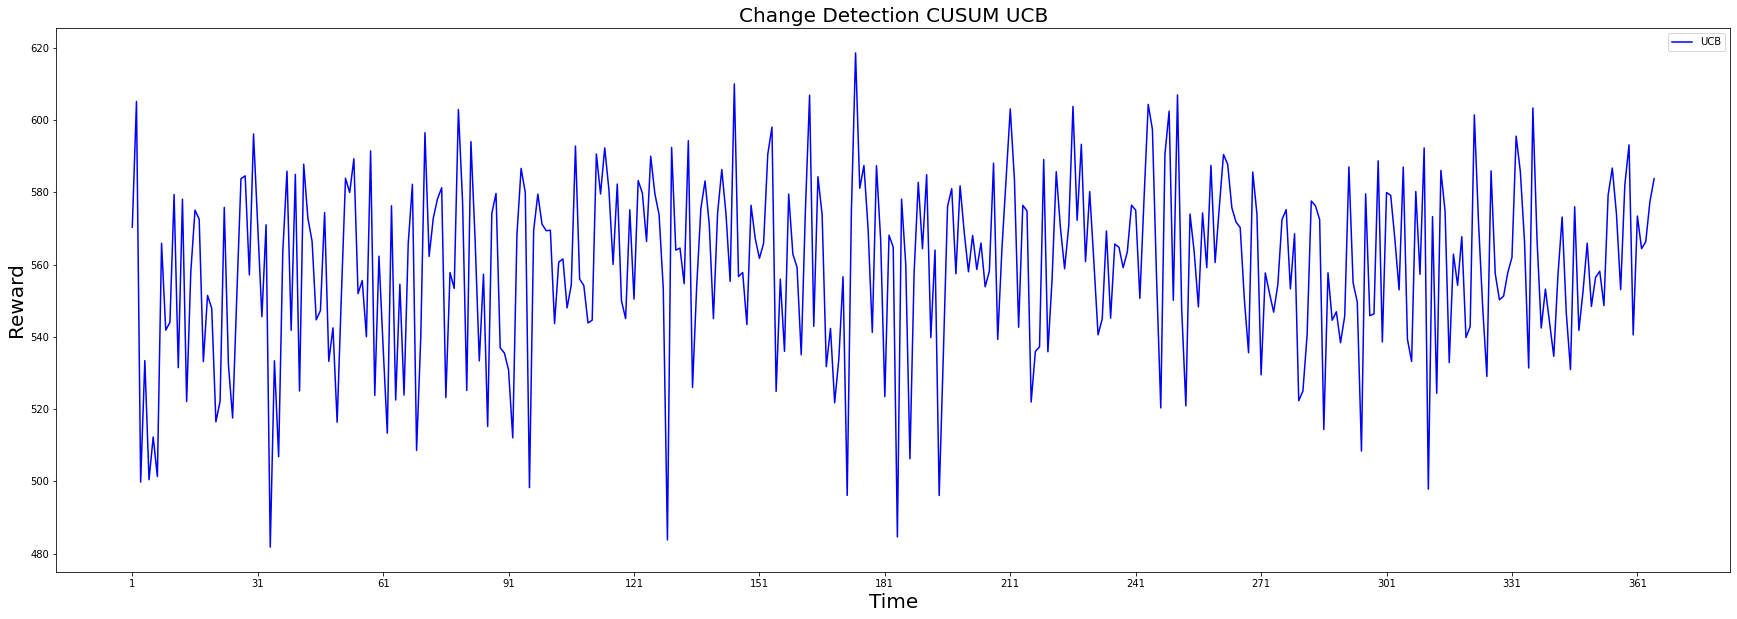

In [66]:
plt.figure(figsize=(30, 10))
#plt.ylim(270, 570)

#plt.plot(time_periods, optimum_means1, color='#34ff00', linestyle='-', linewidth=3.5, label="Optimum")
plt.plot(time_periods, UCB_mean_rewards_per_round, color='blue', linestyle='-', label="UCB")
#plt.plot(time_periods, TS_mean_rewards_per_round, color='red', linestyle='-', label="TS")

plt.xlabel('Time',fontsize=20)
plt.ylabel('Reward',fontsize=20)
plt.title('Change Detection CUSUM UCB',fontsize=20)

plt.xticks(time_periods[::30])
plt.legend()
plt.show()

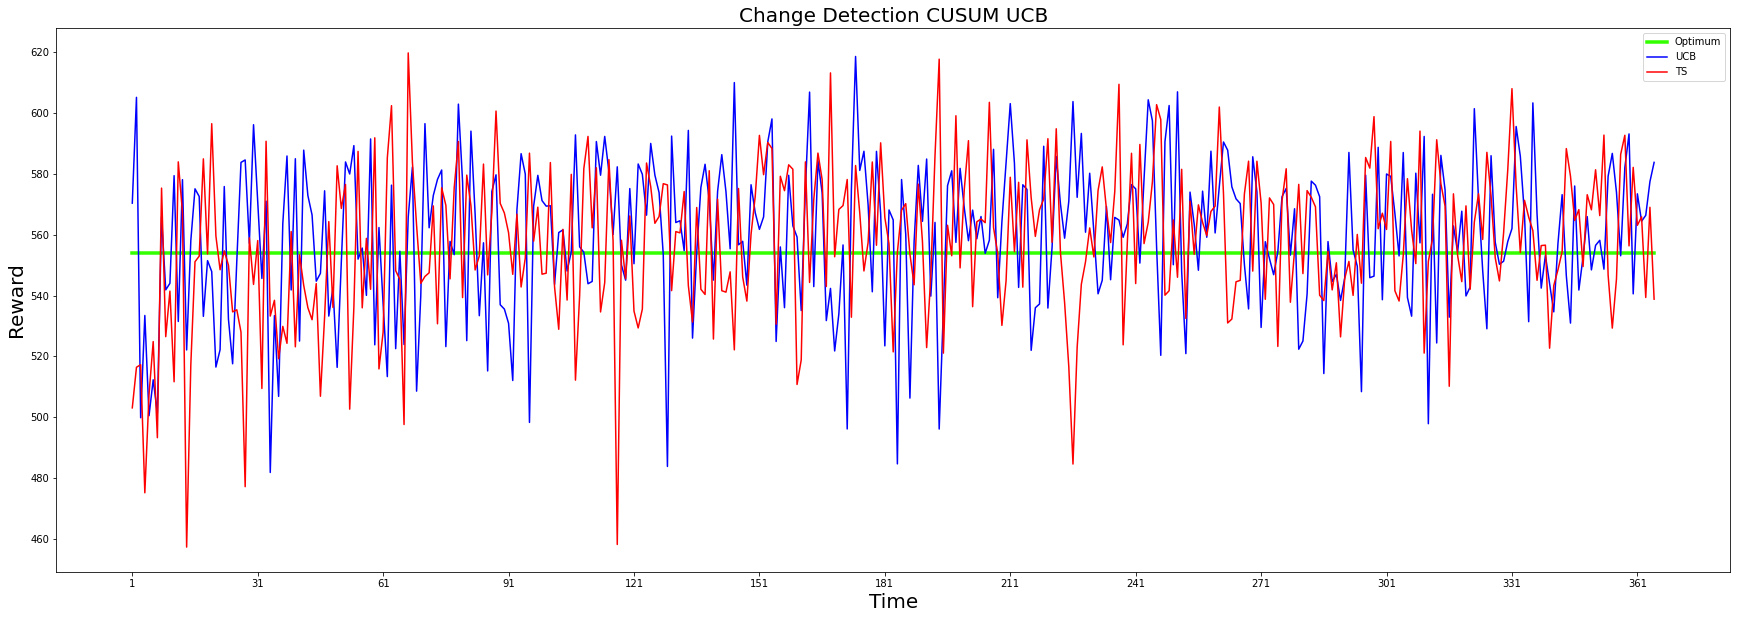

In [63]:
plt.figure(figsize=(30, 10))
#plt.ylim(270, 570)

plt.plot(time_periods, optimum_means1, color='#34ff00', linestyle='-', linewidth=3.5, label="Optimum")
plt.plot(time_periods, UCB_mean_rewards_per_round, color='blue', linestyle='-', label="UCB")
plt.plot(time_periods, TS_mean_rewards_per_round, color='red', linestyle='-', label="TS")

plt.xlabel('Time',fontsize=20)
plt.ylabel('Reward',fontsize=20)
plt.title('Istantaneous Reward',fontsize=20)

plt.xticks(time_periods[::30])
plt.legend()
plt.show()

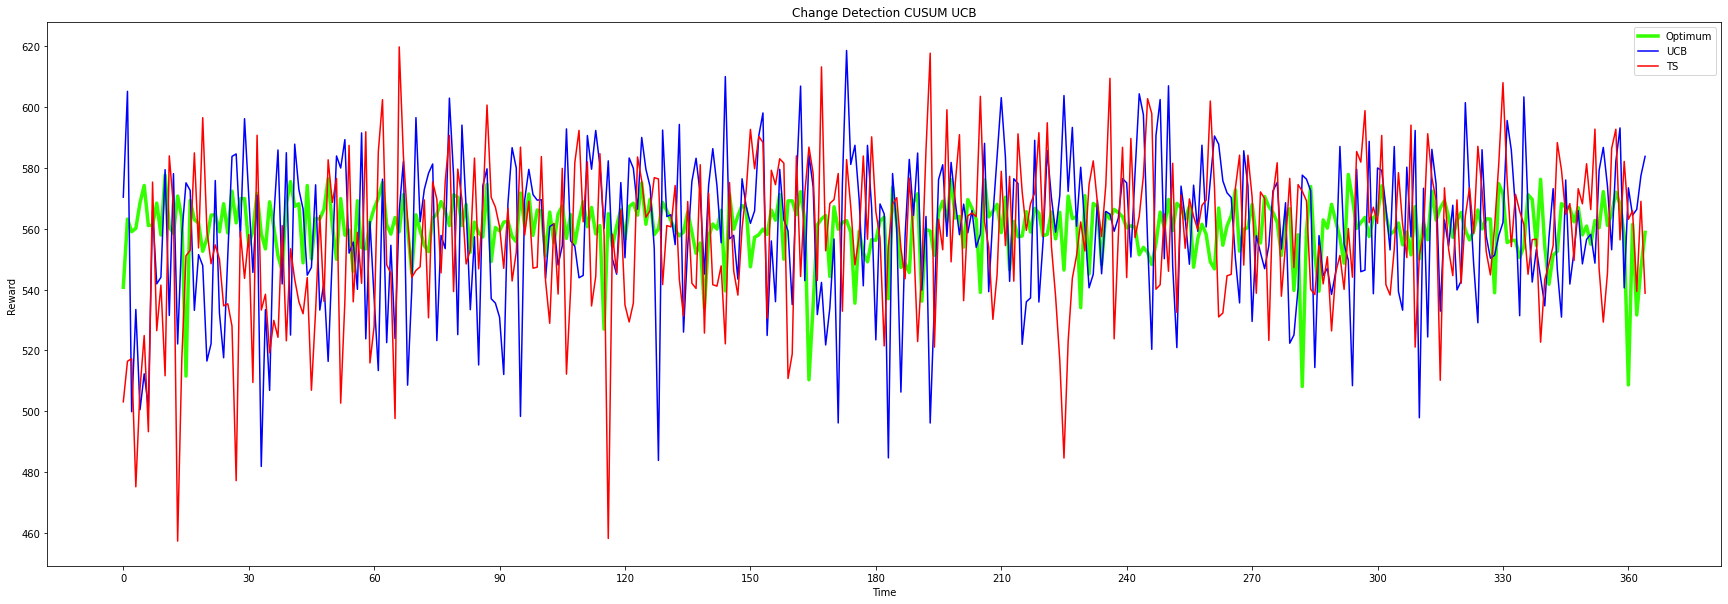

In [53]:
plt.figure(figsize=(30, 10))
#plt.ylim(270, 570)

plt.plot(time_periods, optimum_means, color='#34ff00', linestyle='-', linewidth=3.5, label="Optimum")
plt.plot(time_periods, UCB_mean_rewards_per_round, color='blue', linestyle='-', label="UCB")
plt.plot(time_periods, TS_mean_rewards_per_round, color='red', linestyle='-', label="TS")

plt.xlabel('Time')
plt.ylabel('Reward')
plt.title('Change Detection CUSUM UCB')

plt.xticks(time_periods[::30])
plt.legend()
plt.show()

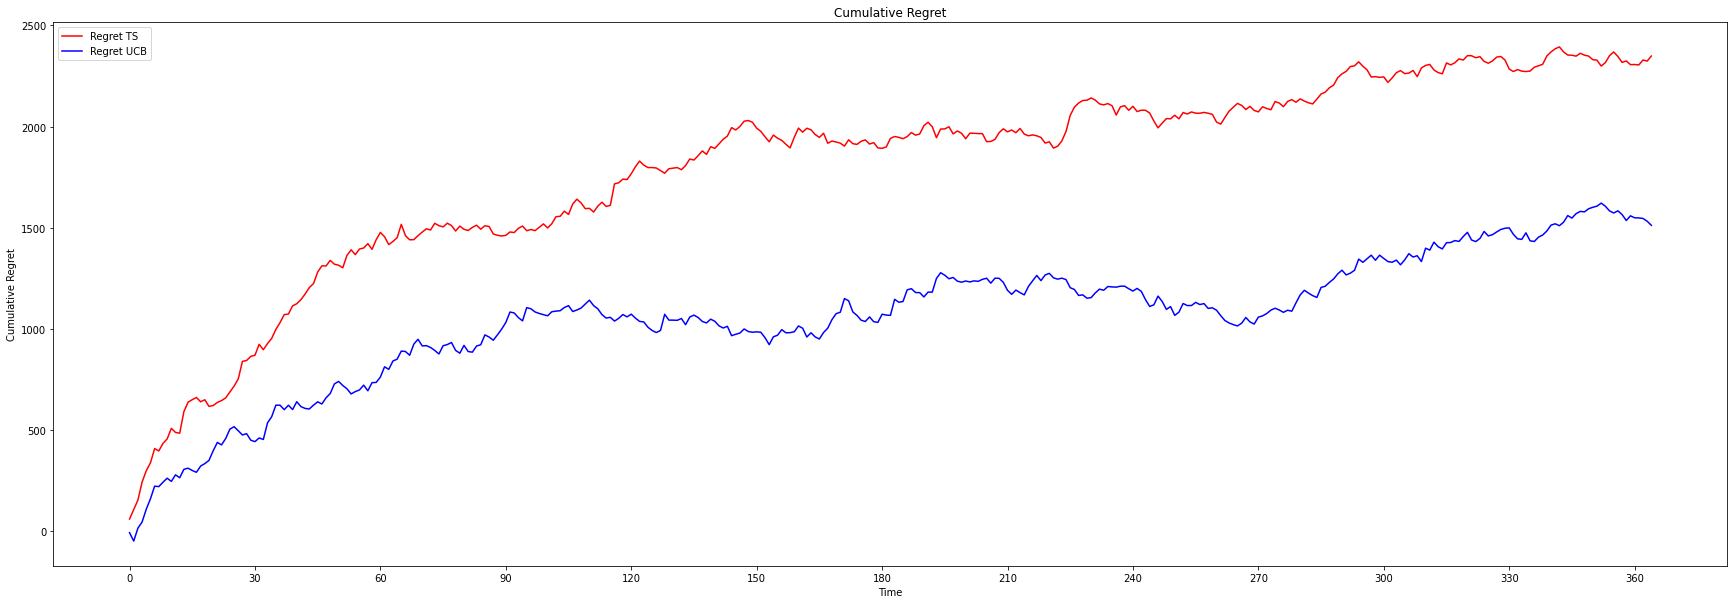

In [50]:
import numpy as np
import matplotlib.pyplot as plt

T = 365
time_periods = range(T)


# Calculate the cumulative differences
diff_TS = np.cumsum([opt - ts for opt, ts in zip(optimum_means1, TS_mean_rewards_per_round)])
diff_UCB = np.cumsum([opt - ucb for opt, ucb in zip(optimum_means1, UCB_mean_rewards_per_round)])

plt.figure(figsize=(30, 10))

# Plot the cumulative differences
plt.plot(time_periods, diff_TS, color='red', linestyle='-', label="Regret TS")
plt.plot(time_periods, diff_UCB, color='blue', linestyle='-', label="Regret UCB")

plt.xlabel('Time')
plt.ylabel('Cumulative Regret')
plt.title('Cumulative Regret')

plt.xticks(time_periods[::30])
plt.legend()
plt.show()

